In [2]:
from sqlalchemy import create_engine
import pandas as pd
import requests

In [3]:
def api_request_get_center(address):
    try:
        url = f"https://nominatim.openstreetmap.org/search.php?q={address}&polygon_geojson=1&format=jsonv2"
        response = requests.get(url)

        lat = response.json()[0]['lat']
        long = response.json()[0]['lon']

        return f"{lat}, {long}"
    
    except Exception:
        print(address)
        return None

## 1. Xử lý dữ liệu

### 1.1 Load CSV

In [4]:
provinces = pd.read_csv('./csv/provinces.csv', dtype={'code': 'string'})
districts = pd.read_csv('./csv/districts.csv', dtype={'code': 'string', 'province_code': 'string'})
wards = pd.read_csv('./csv/wards.csv', dtype={'code': 'string', 'district_code': 'string'})

### 1.2 Xử lý dữ liệu Wards

In [5]:
wards_temp = wards.merge(
    right=districts[['code', 'full_name', 'province_code']],
    left_on='district_code',
    right_on='code',
    how='left'
).merge(
    right=provinces[['code', 'full_name']],
    left_on='province_code',
    right_on='code',
    how='left'
).drop(columns=['code', 'code_y']).rename(
    columns={
        "code_x": "code",
        "full_name": "province_name",
        "full_name_y": "district_name",
        "full_name_x": "ward_name",
    }
)

In [6]:
wards_temp.sample(3)

,code,name,name_en,ward_name,full_name_en,code_name,district_code,center,district_name,province_code,province_name
2260,07048,Vũ Oai,Vu Oai,Xã Vũ Oai,Vu Oai Commune,vu_oai,193,NaN,Thành phố Hạ Long,22,Tỉnh Quảng Ninh
10139,31042,Vân Khánh,Van Khanh,Xã Vân Khánh,Van Khanh Commune,van_khanh,909,"9.5749637, 104.8600441",Huyện An Minh,91,Tỉnh Kiên Giang
9604,29512,1,1,Phường 1,Ward 1,1,851,"9.6373988, 106.4963381",Thị xã Duyên Hải,84,Tỉnh Trà Vinh


Tổng: 10598 xã
Không có tọa độ: 3510 xã
Có tọa độ: 7088 xã


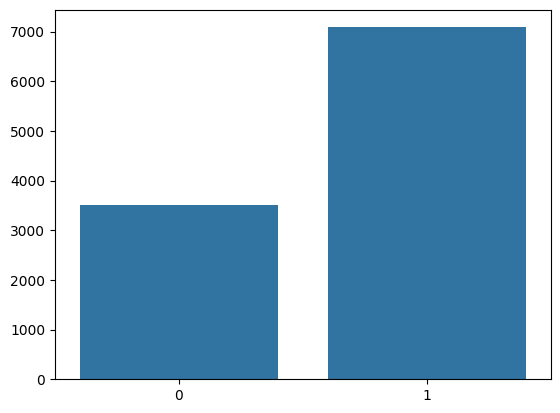

In [17]:
import seaborn as sns

def draw():
    isna = wards['center'].isna().sum()
    notna = wards['center'].notna().sum()
    sns.barplot([isna, notna])

    s = f"Tổng: {isna + notna} xã\nKhông có tọa độ: {isna} xã\nCó tọa độ: {notna} xã"

    print(s)

draw()

## 2. ETL

In [8]:
from models import *

def ETL_data(db_engine):
    # db.metadata.create_all(db_engine)
    
    provinces.to_sql("Provinces", con=db_engine, index=False, if_exists="append")
    districts.to_sql("Districts", con=db_engine, index=False, if_exists="append")
    wards.to_sql("Wards", con=db_engine, index=False, if_exists="append")


### 2.1 CSV

In [9]:
# wards.to_csv('csv/wards.csv', index=False)
# districts.to_csv('csv/districts.csv', index=False)
# provinces.to_csv('csv/provinces.csv', index=False)

### 2.2 SQLite

In [10]:
# SQLite_URL = "sqlite:///app_dev.db"
# sqlite_engine = create_engine(SQLite_URL)

# ETL_data(sqlite_engine)

### 2.3 MySQL

In [11]:
# DB_USER = "cameras_label_master"
# DB_PASS = "aipt2023"
# DB_HOST = "localhost"
# DB_NAME = "cameras_label_master"

# MySQL_URL = f"mysql://{DB_USER}:{DB_PASS}@{DB_HOST}/{DB_NAME}"
# mysql_engine = create_engine(MySQL_URL)

# ETL_data(mysql_engine)